In [1]:
import warnings
warnings.filterwarnings("ignore")
import os
import numpy as np
import pandas as pd
import seaborn as sns
import xgboost as xgb
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from xgboost import plot_importance, plot_tree
from sklearn.model_selection import train_test_split
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, TimeSeriesSplit

In [2]:
def PlotDecomposition(result):
    plt.figure(figsize=(22,18))
    plt.subplot(4,1,1)
    plt.plot(result.observed,label='Observed',lw=1)
    plt.legend(loc='upper left')
    plt.subplot(4,1,2)
    plt.plot(result.trend,label='Trend',lw=1)
    plt.legend(loc='upper left')
    plt.subplot(4, 1, 3)
    plt.plot(result.seasonal, label='Seasonality',lw=1)
    plt.legend(loc='upper left')
    plt.subplot(4, 1, 4)
    plt.plot(result.resid, label='Residuals',lw=1)
    plt.legend(loc='upper left')
    plt.show()
def CalculateError(pred,sales):
    percentual_errors = []
    for A_i, B_i in zip(sales, pred):
        percentual_error = abs((A_i - B_i) / B_i)
        percentual_errors.append(percentual_error)
    return sum(percentual_errors) / len(percentual_errors)
def PlotPredictions(plots,title):
    plt.figure(figsize=(18, 8))
    for plot in plots:
        plt.plot(plot[0], plot[1], label=plot[2], linestyle=plot[3],color=plot[4],lw=1)
    plt.xlabel('Date')
    plt.ylabel("Trips")
    plt.title(title)
    plt.legend()
    plt.xticks(rotation=30, ha='right')
    plt.show()
def create_lagged_features(data, window_size):
    X, y = [], []
    for i in range(len(data)- window_size):
        X.append(data[i:i+window_size])
        y.append(data[i+window_size])
    return np.array(X), np.array(y)

In [4]:
files = []

 # Get all uber rides raw data
for dirname, _, filenames in os.walk('D:/Notes/Internship/Unified_mentor/CFD/csv/'):
    for filename in filenames:
        #print(os.path.join(dirname, filename))
        files.append(os.path.join(dirname, filename)) if "raw" in filename else None

In [5]:
# Read and concatenate all CSV files
dataframes = [pd.read_csv(file) for file in files]
uber2014 = pd.concat(dataframes, ignore_index=True)

# Now make sure the date column is set to datetime, sorted and with an adequate name
uber2014['Date/Time'] = pd.to_datetime(uber2014['Date/Time'], format='%m/%d/%Y %H:%M:%S')
uber2014 = uber2014.sort_values(by='Date/Time')
uber2014 = uber2014.rename(columns={'Date/Time':'Date'})
uber2014.set_index('Date',inplace=True)

In [8]:
uber2014.head()

,Lat,Lon,Base,Dispatching_base_num,Pickup_date,Affiliated_base_num,locationID
Date,,,,,,,
2014-04-01 00:00:00,40.7215,-73.9952,B02682,NaN,NaN,NaN,NaN
2014-04-01 00:00:00,40.7637,-73.9600,B02598,NaN,NaN,NaN,NaN
2014-04-01 00:00:00,40.7188,-73.9863,B02598,NaN,NaN,NaN,NaN
2014-04-01 00:01:00,40.7355,-73.9966,B02617,NaN,NaN,NaN,NaN
2014-04-01 00:02:00,40.7184,-73.9601,B02682,NaN,NaN,NaN,NaN


In [9]:
# Group by hour and count occurrences of 'Base'
hourly_counts = uber2014['Base'].resample('H').count()
# Convert the series to a dataframe
uber2014 = hourly_counts.reset_index()
# Rename columns for clarity
uber2014.columns = ['Date', 'Count']
uber2014.set_index('Date',inplace=True)

In [10]:
uber2014.head()

,Count
Date,
2014-04-01 00:00:00,138
2014-04-01 01:00:00,66
2014-04-01 02:00:00,53
2014-04-01 03:00:00,93
2014-04-01 04:00:00,166


In [11]:
print(uber2014.index.min())
print(uber2014.index.max())

2014-04-01 00:00:00
2014-09-30 22:00:00


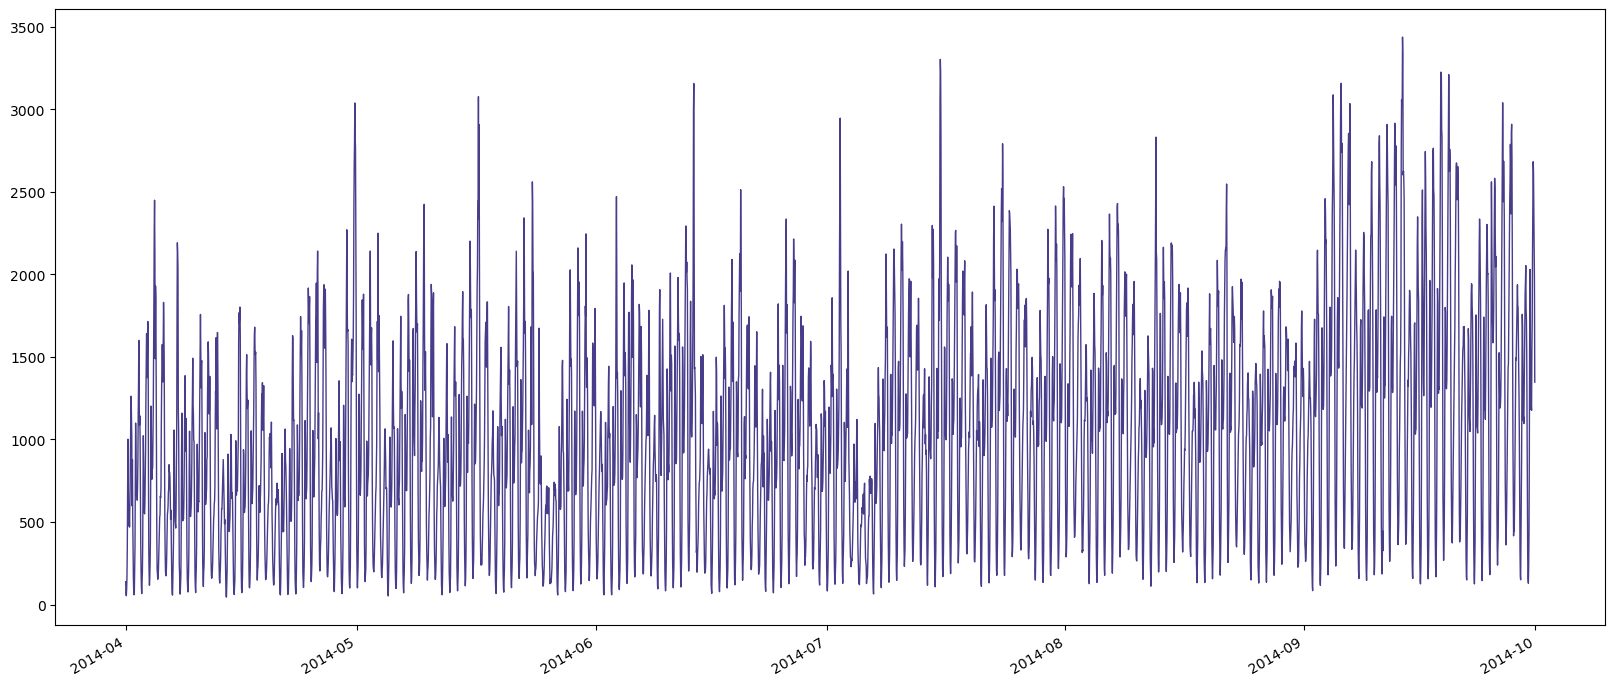

In [12]:
plt.figure(figsize=(20, 8))
plt.plot(uber2014['Count'],linewidth = 1, color='darkslateblue')
plt.xticks(rotation=30,ha='right')
plt.show()

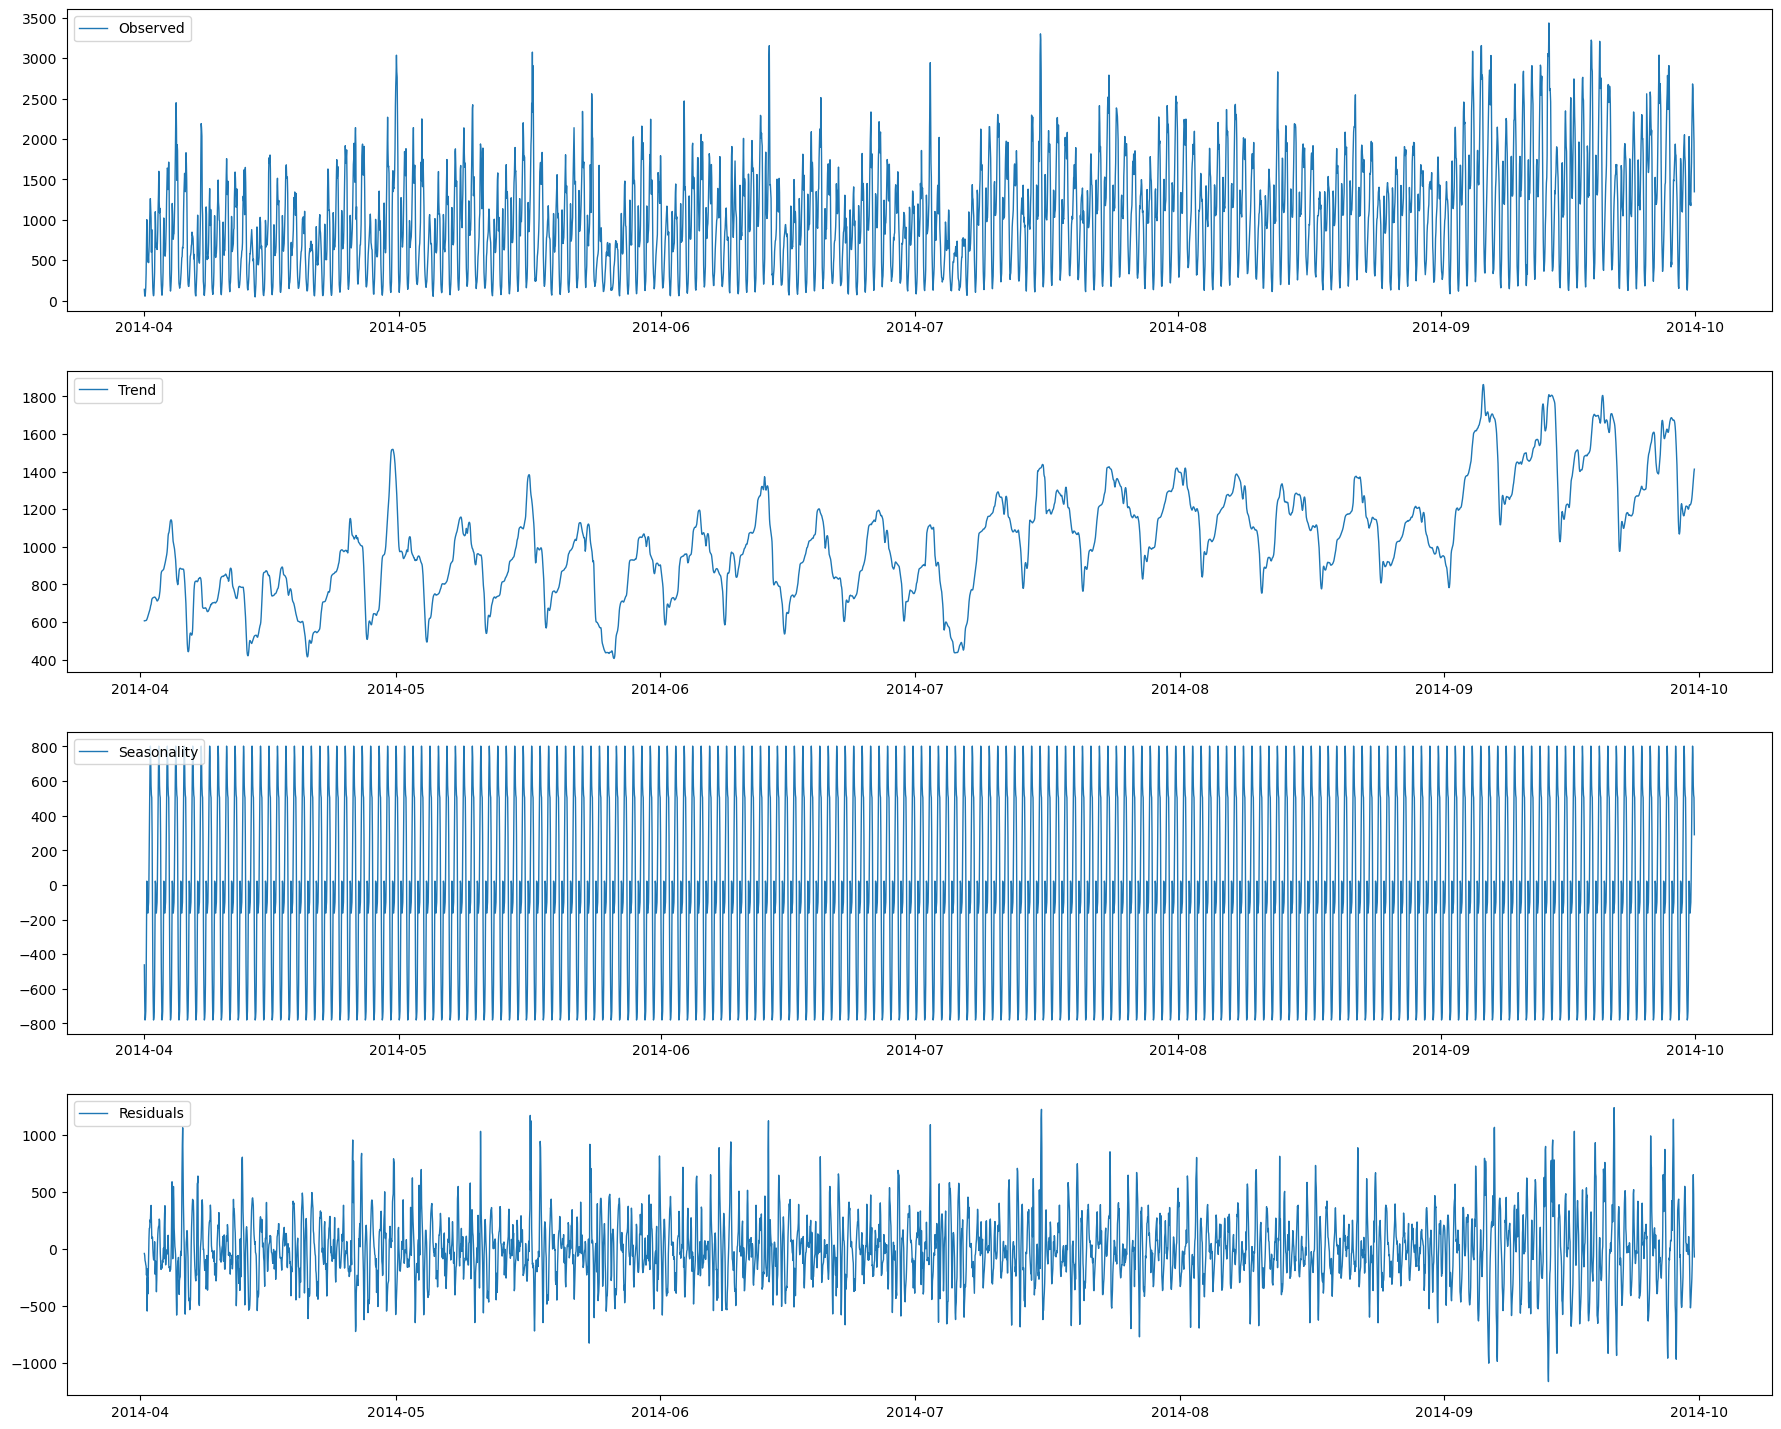

In [13]:
result=seasonal_decompose(uber2014['Count'],model='add', period=24*1)
PlotDecomposition(result)

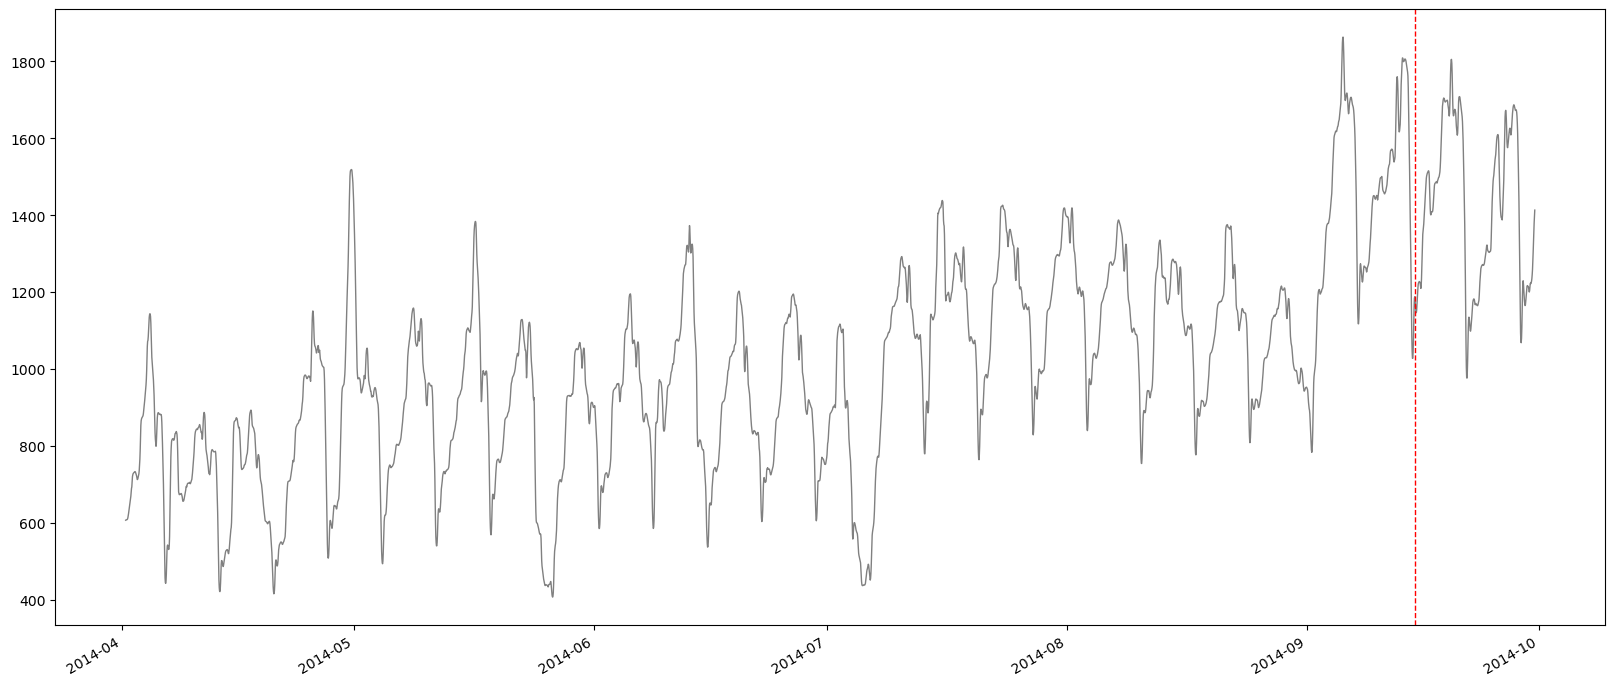

In [14]:
cutoff_date = '2014-09-15 00:00:00'
plt.figure(figsize=(20, 8))
plt.plot(result.trend,linewidth = 1, color='gray')
plt.axvline(x=pd.Timestamp(cutoff_date), color='red', linestyle='--', linewidth=1)
plt.xticks(rotation=30,ha='right')
plt.show()

In [16]:
uber2014

,Count
Date,
2014-04-01 00:00:00,138
2014-04-01 01:00:00,66
2014-04-01 02:00:00,53
2014-04-01 03:00:00,93
2014-04-01 04:00:00,166
...,...
2014-09-30 18:00:00,2625
2014-09-30 19:00:00,2404
2014-09-30 20:00:00,2246


In [17]:
uber2014_train = uber2014.loc[:cutoff_date]
uber2014_test = uber2014.loc[cutoff_date:]

<Axes: title={'center': 'Train / Test Sets'}, xlabel='Date'>

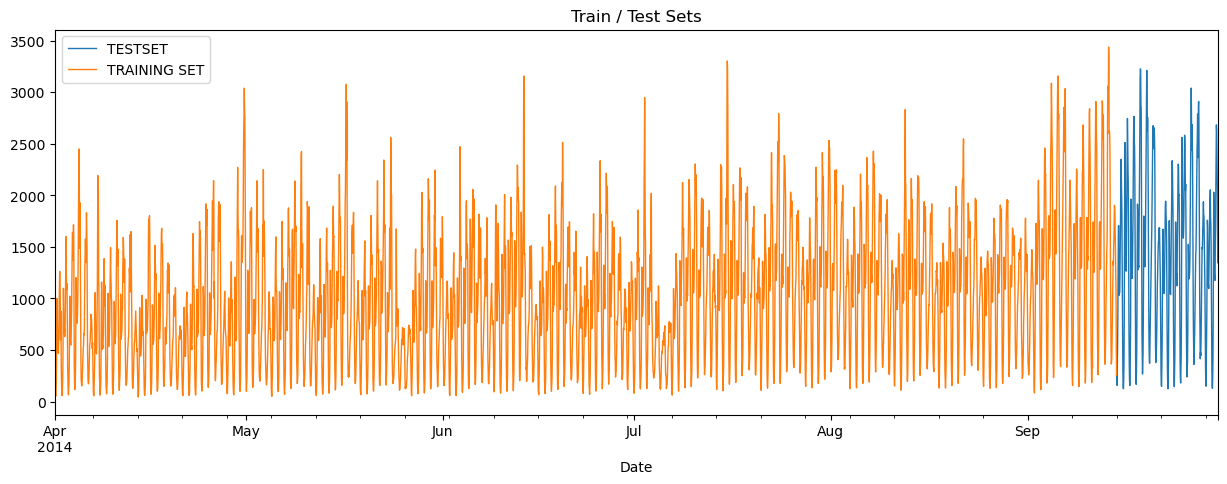

In [18]:
uber2014_test.rename(columns={'Count':'TESTSET'}).join(uber2014_train.rename(columns={'Count':'TRAINING SET'}),how='outer').plot(figsize=(15,5),title='Train / Test Sets', style='-',lw=1)

In [19]:
# Set the window size
window_size = 24
# Split data into training and test sets
X_train, y_train = create_lagged_features(uber2014_train['Count'].values, window_size)

In [27]:
print(X_train.shape, y_train.shape)

(3985, 24) (3985,)


In [22]:
test_data = np.concatenate([uber2014_train['Count'].values[-window_size:],uber2014_test['Count'].values])
X_test, y_test = create_lagged_features(test_data, window_size)

In [23]:
seed = 12345

In [24]:
tscv = TimeSeriesSplit(n_splits=5)

In [28]:
xgb_param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 6, 9],
    'learning_rate': [0.01, 0.1, 0.3],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0]
}

In [29]:
xgb_model = xgb.XGBRegressor(objective='reg:squarederror', random_state=seed)

In [30]:
xgb_grid_search = GridSearchCV(estimator=xgb_model, param_grid=xgb_param_grid, cv=tscv, scoring='neg_mean_absolute_percentage_error', n_jobs=-1,verbose=1)
xgb_grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 243 candidates, totalling 1215 fits


GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, device=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, gamma=None,
                                    grow_policy=None, imp...
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None,
                                    multi_strategy=None, n_estimators=None,
                                    n_jobs=None, num_parallel_tree=None,
                                    random_state=12345, ...),
             n_jobs=-1,
             param_grid={'colsample_bytree': [0.6, 0.8, 1.0],
                         'learning_rate': [0.01, 0.1, 0.3],
                         'max_depth': [3, 6, 9],
                         'n_estimators': [100, 200, 300],
                         'subsample': [0.6, 0.8, 1.0]},
             scoring='neg_mean_absolute_percentage_error', verbose=1)

In [32]:
import logging

logging.basicConfig(level=logging.INFO)

xgb_grid_search.fit(X_train, y_train, verbose=2)

Fitting 5 folds for each of 243 candidates, totalling 1215 fits


GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, device=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, gamma=None,
                                    grow_policy=None, imp...
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None,
                                    multi_strategy=None, n_estimators=None,
                                    n_jobs=None, num_parallel_tree=None,
                                    random_state=12345, ...),
             n_jobs=-1,
             param_grid={'colsample_bytree': [0.6, 0.8, 1.0],
                         'learning_rate': [0.01, 0.1, 0.3],
                         'max_depth': [3, 6, 9],
                         'n_estimators': [100, 200, 300],
                         'subsample': [0.6, 0.8, 1.0]},
             scoring='neg_mean_absolute_percentage_error', verbose=1)

In [34]:
print("Best XGBoost parameters:", xgb_grid_search.best_params_)

Best XGBoost parameters: {'colsample_bytree': 1.0, 'learning_rate': 0.1, 'max_depth': 6, 'n_estimators': 300, 'subsample': 0.8}


In [35]:
xgb_predictions = xgb_grid_search.best_estimator_.predict(X_test)

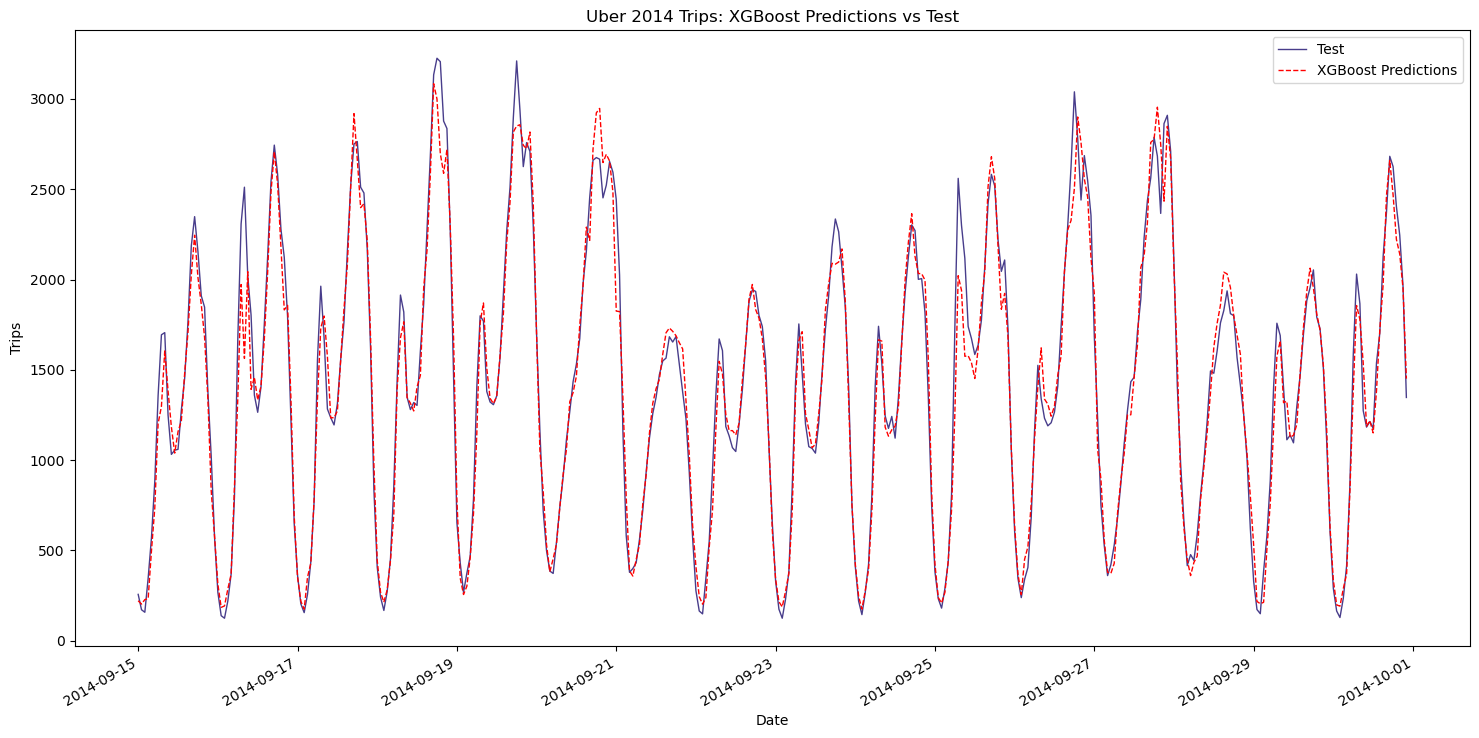

In [36]:
PlotPredictions([
    (uber2014_test.index,uber2014_test['Count'],'Test','-','darkslateblue'),
    (uber2014_test.index,xgb_predictions,'XGBoost Predictions','--','red')],
    'Uber 2014 Trips: XGBoost Predictions vs Test')

In [39]:
xgb_mape = mean_absolute_percentage_error(uber2014_test['Count'], xgb_predictions)
print(f'XGBoost MAPE:\t\t{xgb_mape:.2%}')

XGBoost MAPE:		8.92%


In [40]:
rf_param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': [None, 'sqrt', 'log2']
}

In [41]:
rf_model = RandomForestRegressor(random_state=seed)

In [42]:
rf_grid_search = GridSearchCV(estimator=rf_model, param_grid=rf_param_grid, cv=tscv,n_jobs=-1, scoring='neg_mean_absolute_percentage_error',verbose = 1)
rf_grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 243 candidates, totalling 1215 fits


GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
             estimator=RandomForestRegressor(random_state=12345), n_jobs=-1,
             param_grid={'max_depth': [10, 20, 30],
                         'max_features': [None, 'sqrt', 'log2'],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [100, 200, 300]},
             scoring='neg_mean_absolute_percentage_error', verbose=1)

In [43]:
print("Best Random Forest parameters:", rf_grid_search.best_params_)

Best Random Forest parameters: {'max_depth': 30, 'max_features': None, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 100}


In [44]:
rf_predictions = rf_grid_search.best_estimator_.predict(X_test)

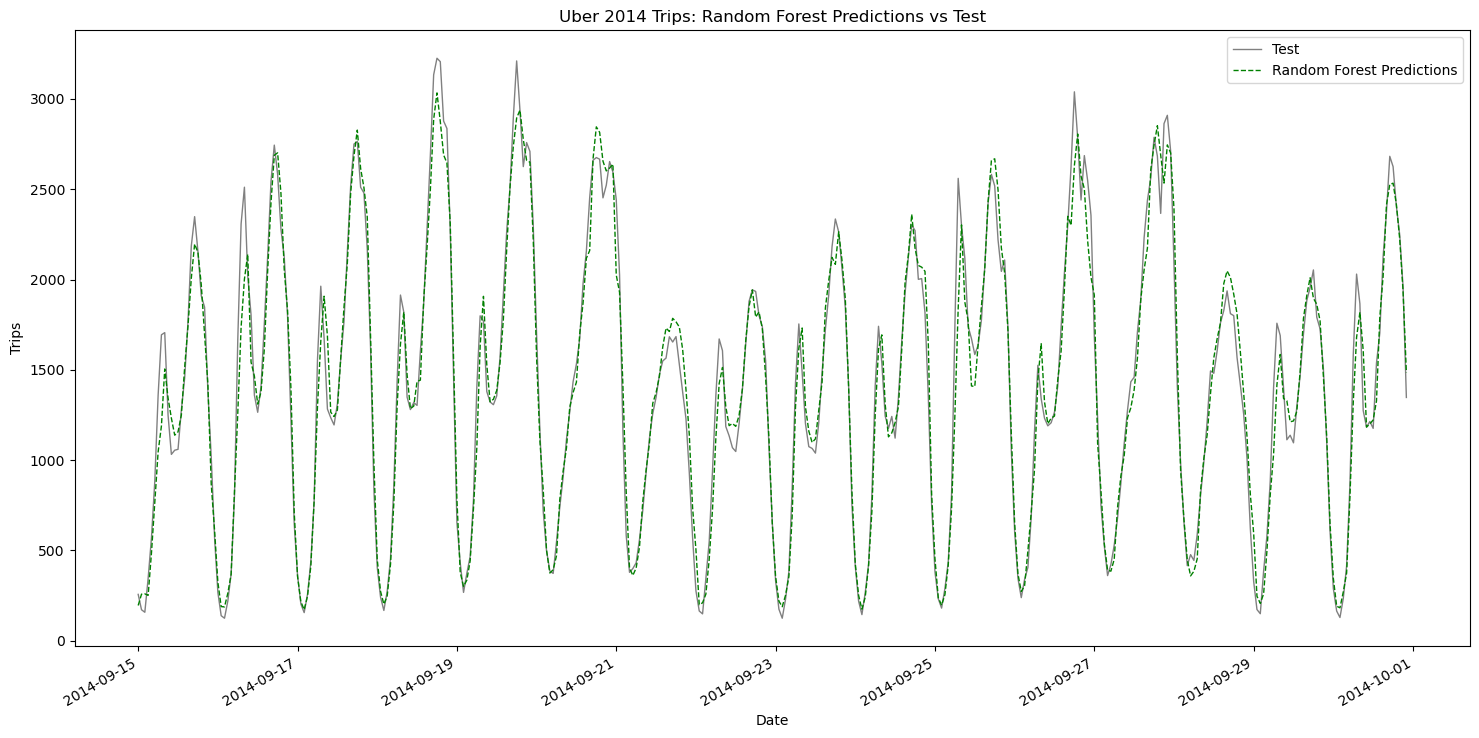

In [45]:
PlotPredictions([(uber2014_test.index,uber2014_test['Count'],'Test','-','gray'),(uber2014_test.index,rf_predictions,'Random Forest Predictions','--','green')],'Uber 2014 Trips: Random Forest Predictions vs Test')

In [46]:
rf_mape = mean_absolute_percentage_error(uber2014_test['Count'], rf_predictions)
print(f'Random Forest Mean Percentage Error:\t{rf_mape:.2%}')

Random Forest Mean Percentage Error:	9.61%


In [47]:
gbr_param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.1],
    'max_depth': [3, 4, 5],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2']
}

In [48]:
gbr_model = GradientBoostingRegressor(random_state=seed)

In [49]:
gbr_grid_search = GridSearchCV(estimator=gbr_model, param_grid=gbr_param_grid,cv=tscv, n_jobs=-1, scoring='neg_mean_absolute_percentage_error',verbose = 1)
gbr_grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 324 candidates, totalling 1620 fits


GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
             estimator=GradientBoostingRegressor(random_state=12345), n_jobs=-1,
             param_grid={'learning_rate': [0.01, 0.1], 'max_depth': [3, 4, 5],
                         'max_features': ['sqrt', 'log2'],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [100, 200, 300]},
             scoring='neg_mean_absolute_percentage_error', verbose=1)

In [50]:
print("Best Random Forest parameters:", gbr_grid_search.best_params_)

Best Random Forest parameters: {'learning_rate': 0.1, 'max_depth': 5, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 300}


In [51]:
gbr_predictions = gbr_grid_search.best_estimator_.predict(X_test)

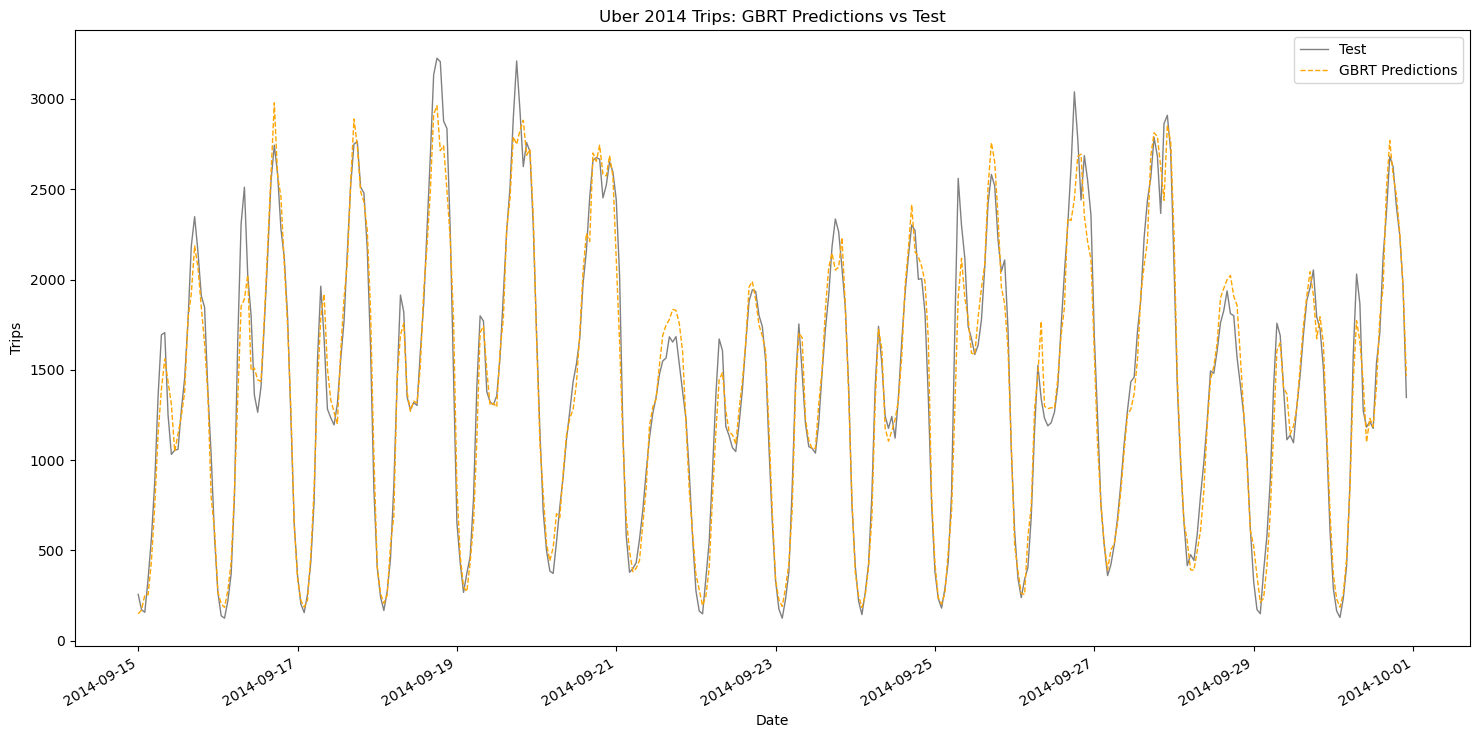

In [52]:
PlotPredictions([(uber2014_test.index,uber2014_test['Count'],'Test','-','gray'),(uber2014_test.index,gbr_predictions,'GBRT Predictions','--','orange')],'Uber 2014 Trips: GBRT Predictions vs Test')


In [53]:
gbr_mape = mean_absolute_percentage_error(y_test, gbr_predictions)
print(f'GBTR Percentage Error:\t{gbr_mape:.2%}')

GBTR Percentage Error:	10.02%


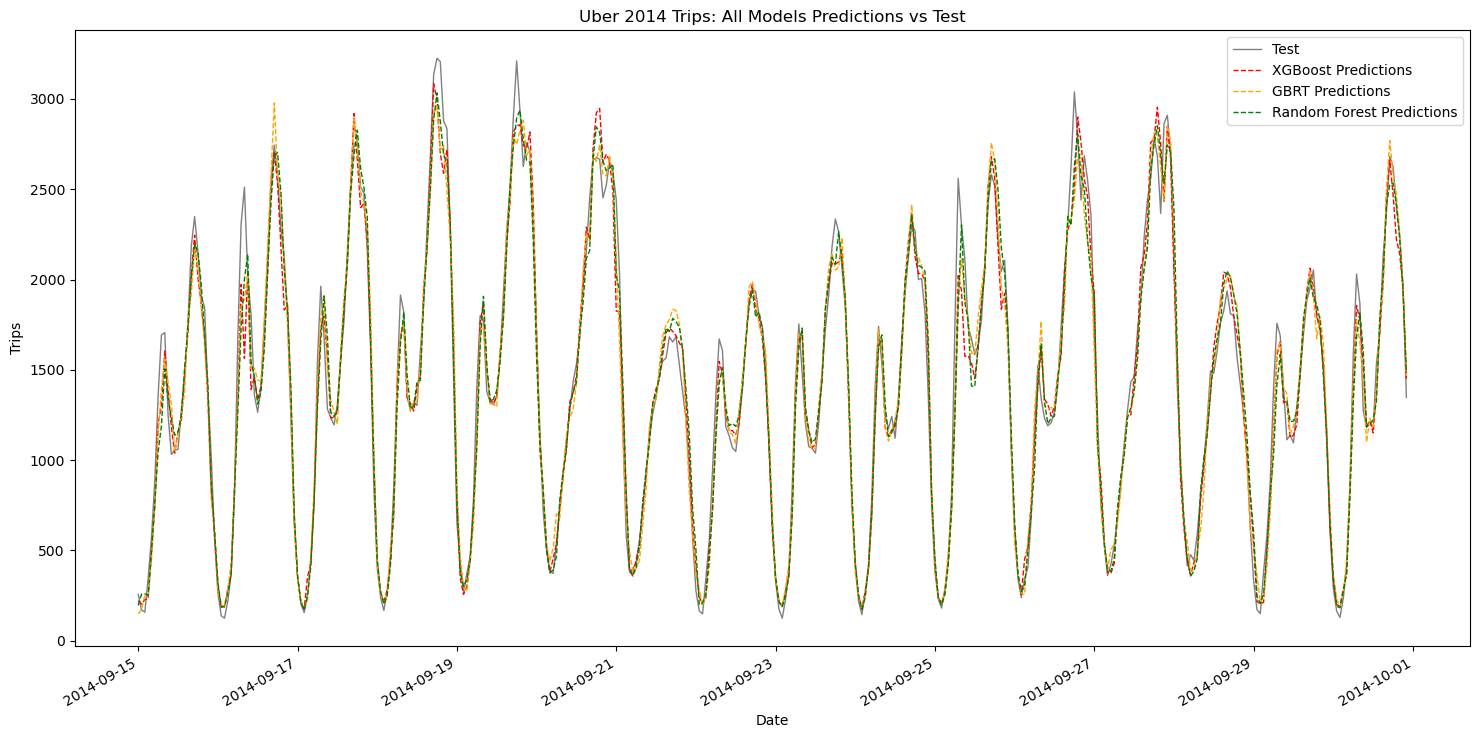

In [54]:
PlotPredictions([
    (uber2014_test.index,uber2014_test['Count'],'Test','-','gray'),
    (uber2014_test.index,xgb_predictions,'XGBoost Predictions','--','red'),
    (uber2014_test.index,gbr_predictions,'GBRT Predictions','--','orange'),
    (uber2014_test.index,rf_predictions,'Random Forest Predictions','--','green')],
    'Uber 2014 Trips: All Models Predictions vs Test')

In [56]:
print(f'XGBoost MAPE:\t\t\t{xgb_mape:.2%}')
print(f'Random Forest MAPE:\t\t{rf_mape:.2%}')
print(f'GBTR Percentage Error:\t\t{gbr_mape:.2%}')

XGBoost MAPE:			8.92%
Random Forest MAPE:		9.61%
GBTR Percentage Error:		10.02%


In [58]:
1/8.92

0.11210762331838565

In [59]:
1/9.61

0.10405827263267431

In [60]:
1/10.02

0.0998003992015968

In [62]:
0.368*0.112

0.041216

In [63]:
weights = np.array([0.368, 0.322, 0.310])

In [64]:
ensemble_predictions = (weights[0] * xgb_predictions + weights[1] * rf_predictions + weights[2] * gbr_predictions)

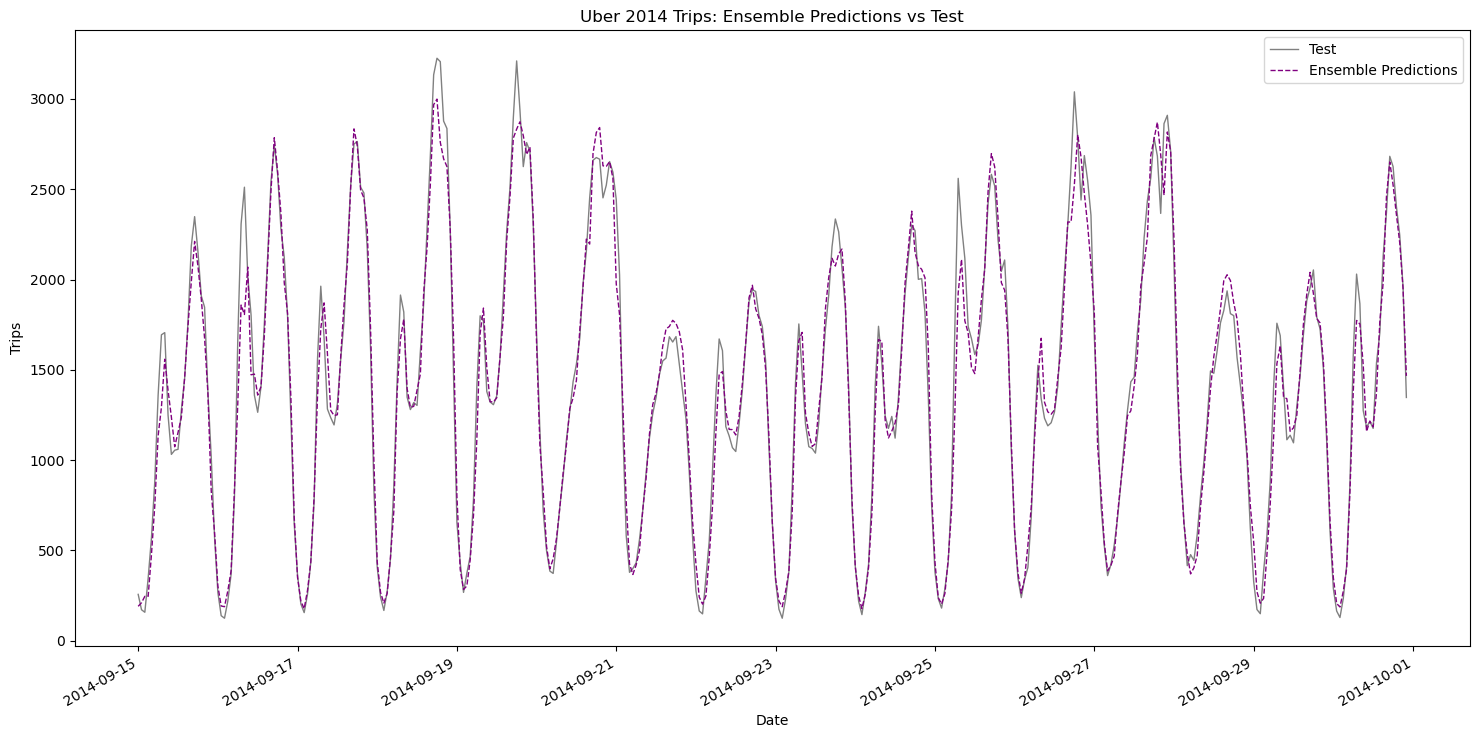

In [65]:
PlotPredictions([
    (uber2014_test.index,uber2014_test['Count'],'Test','-','gray'),
    (uber2014_test.index,ensemble_predictions,'Ensemble Predictions','--','purple')],
    'Uber 2014 Trips: Ensemble Predictions vs Test')

In [66]:
ensemble_mape = mean_absolute_percentage_error(uber2014_test['Count'],ensemble_predictions)
print(f'Ensemble MAPE:\t{ensemble_mape:.2%}')

Ensemble MAPE:	8.81%


In [67]:
print(f'XGBoost MAPE:\t\t{xgb_mape:.2%}')
print(f'Random Forest MAPE:\t{rf_mape:.2%}')
print(f'GBTR MAPE:\t\t{gbr_mape:.2%}')
print(f'Ensemble MAPE:\t\t{ensemble_mape:.2%}')

XGBoost MAPE:		8.92%
Random Forest MAPE:	9.61%
GBTR MAPE:		10.02%
Ensemble MAPE:		8.81%
